In [1]:
import pandas as pd
import numpy as np
import operator
import os
from pathlib import Path
cwd = os.getcwd() # get path of current working directory
main_folder = str(Path(cwd).parents[0]) # main folder is the lowest level in project

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns; sns.set_theme()


In [2]:
cex84_02 = pd.read_stata(main_folder + "\data\cex84_02.dta")
cex84_02 = cex84_02[cex84_02.year >= 94]
cex84_02 = cex84_02[cex84_02.year <= 97]
cex84_02['ee'] = 0
cex84_02.loc[(cex84_02['year'] <=95) & (cex84_02['educatio'] >=21), 'ee'] = 1
cex84_02.loc[(cex84_02['year'] >=96) & (cex84_02['educatio'] >=40), 'ee'] = 1
cex84_02['meanee'] = cex84_02['ee'].mean()
#cex84_02

In [3]:
#Summary statistics
cex84_02[["meanee"]].describe()

,meanee
count,2.330100e+04
mean,5.216943e-01
std,1.036971e-13
min,5.216943e-01
25%,5.216943e-01
50%,5.216943e-01
75%,5.216943e-01
max,5.216943e-01


In [4]:
#Total expenditure
cex84_02['totalexp1'] = cex84_02.loc[:, 'foodhome':'charity'].sum(axis=1)
cex84_02['totalexp'] = cex84_02['totalexp1'] + cex84_02['ohint'] + cex84_02['ohtax'] + cex84_02['ohmaint']
cex84_02 = cex84_02.drop(columns=['totalexp1'])
#cex84_02

In [5]:
#Expenditure used in this paper
cex84_02 = cex84_02.drop(columns=['autos'])
cex84_02['tt'] = cex84_02.loc[:, 'foodhome':'charity'].sum(axis=1)
cex84_02 = cex84_02[cex84_02.tt >= 0]
cex84_02['ltotexp'] = np.log(cex84_02['tt']) - np.log(cex84_02['cpi_97'])
#cex84_02

In [6]:
cex84_02_div = pd.read_stata('cex84_02_div.dta')
cex84_02_div = cex84_02_div.drop(columns=['gambling', 'toiletry', 'housuppl'])
#cex84_02_div

In [7]:
#Aggregate some small expenses with similar expenses
cex84_02_div['foodout'] = cex84_02_div['foodout'] + cex84_02_div['foodwork'] 
cex84_02_div['renthome'] = cex84_02_div['renthome'] + cex84_02_div['rentothr']
cex84_02_div['pubs'] = cex84_02_div['pubs'] + cex84_02_div['books']
cex84_02_div['hospital'] = cex84_02_div['hospital'] + cex84_02_div['nurshome']
cex84_02_div['masstran'] = cex84_02_div['masstran'] + cex84_02_div['tolls']
cex84_02_div = cex84_02_div.drop(columns=['foodwork', 'rentothr', 'books', 'nurshome', 'tolls'])
#cex84_02_div

In [8]:
cex84_02_div['single'] = 1
cex84_02.loc[cex84_02['wife_ed'] >=1, 'single'] = 0 
cex84_02_div['wifeH'] = 0
cex84_02_div.loc[cex84_02_div['wife_ed'] >=2, 'wifeH'] = 1 #/*spouse with some college, wife_ed with college ==3*/

In [9]:
#Table descriptive
cex84_02_div['exptot97'] = np.log(cex84_02_div['totalexp']/cex84_02_div['cpi_97'])
cex84_02_div['expnondur97'] = np.log(cex84_02_div['tt']/cex84_02_div['cpi_97'])
cex84_02_div['wages97'] = np.log(cex84_02_div['income']/cex84_02_div['cpi_97'])
cex84_02_div['sex'] = cex84_02_div['sex'] - 1
#cex84_02_div

C:\Users\gimat\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gimat\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
cex84_02_div.rename(columns={'foodhome':'share_1', 'foodout':'share_2', 'tobacco':'share_3', 'alcohol':'share_4', 'niteclub':'share_5', 'clothes':'share_6','tailors':'share_7', 'jewelry':'share_8', 'hlthbeau':'share_9', 'renthome':'share_10', 'furnish':'share_11', 'elect':'share_12', 'gas':'share_13','water':'share_14', 'homefuel':'share_15','telephon':'share_16', 'servants':'share_17', 'drugs':'share_18', 'orthopd':'share_19', 'doctors':'share_20', 'hospital':'share_21', 'helthins':'share_22', 'busiserv':'share_23', 'lifeins':'share_24', 'parts':'share_25','carservs':'share_26', 'gasoline':'share_27', 'autoins':'share_28', 'masstran':'share_29', 'othtrans':'share_30', 'airfare':'share_31', 'pubs':'share_32', 'recsport':'share_33', 'othrec':'share_34', 'highedu':'share_35','lowedu':'share_36', 'othedu':'share_37', 'charity':'share_38'}, inplace=True)
#cex84_02_div

In [11]:
filter_col = [col for col in cex84_02_div if col.startswith('share')]

In [12]:
cex84_02_div = cex84_02_div[['share_1','share_2', 'share_3', 'share_4', 'share_5', 'share_6', 'share_7', 'share_8', 'share_9',
                             'share_10', 'share_11', 'share_12', 'share_13', 'share_14', 'share_15', 'share_16', 'share_17',
                             'share_18', 'share_19', 'share_20', 'share_21', 'share_22', 'share_23', 'share_24', 'share_25',
                             'share_26', 'share_27','share_28', 'share_29', 'share_30', 'share_31', 'share_32', 'share_33',
                             'share_34', 'share_35', 'share_36', 'share_37', 'share_38','year', 'ltotexp', 'age', 'ee', 'sex',
                             'nchild', 'meanee']]
#cex84_02_div

In [13]:
cex84_02_div['id'] = np.arange(1, len(cex84_02_div)+1)
#cex84_02_div

In [14]:
#wide to long 
wide_to_long = pd.read_stata('wide_to_long.dta')
#wide_to_long

In [15]:
wl1 = wide_to_long.groupby('ind')['share', 'meanee'].mean()
wl2 = wide_to_long.groupby('ind')['share'].agg(['std'])
wl3 = pd.merge(wl1, wl2, on='ind').rename(columns={'std': 'sigmash'})
wl3['sigmash'] = wl3['sigmash']**2
#wl3 

<ipython-input-15-8c549cfab8b1>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wl1 = wide_to_long.groupby('ind')['share', 'meanee'].mean()


In [16]:
wl3.to_stata('shares')

In [17]:
dummies = pd.get_dummies(wide_to_long['ind'])
wide_to_long_w_dummies = pd.concat([wide_to_long, dummies], axis=1)
#wide_to_long_w_dummies

In [18]:
#Unable to allocate 5.70 TiB for an array with shape (885286, 885324) and data type float64
# ltotexp_dum = dummies*wide_to_long['ltotexp']

In [19]:
shares_reg = pd.read_stata('shares_reg.dta')
#shares_reg

In [20]:
shares_reg['id'] = np.arange(1, len(shares_reg)+1)

In [21]:
shares_reg_long = pd.wide_to_long(shares_reg,["bdum", "gdum", "sbdum", "sgdum"], i='id', j="ind")

In [22]:
shares = pd.read_stata('shares')
shares_joint = pd.merge(shares_reg_long, shares, on='ind')
shares_joint.rename(columns={'bdum':'incomebeta', 'gdum':'educbeta', 'share':'meansh'}, inplace=True)
shares_joint['sigmaincome'] = shares_joint['sbdum'] 
shares_joint['sigmaedu'] = shares_joint['sgdum'] 
#shares_joint

In [23]:
shares_joint['elastincome'] = (shares_joint['incomebeta']/shares_joint['meansh'])+1
shares_joint['sigmaincome']  = shares_joint['sigmaincome'] **2/shares_joint['meansh'] **2
shares_joint['sigmaincome']  = shares_joint['sigmaincome'] **(1/2)

shares_joint['elastedu'] = (shares_joint['educbeta']*shares_joint['meanee'])/shares_joint['meansh']
shares_joint['sigmaedu']  = shares_joint['sigmaedu'] **2*(shares_joint['meanee']/shares_joint['meansh'])**2
shares_joint['sigmaedu']  = shares_joint['sigmaedu'] **(1/2)

#shares_joint

In [24]:
shares_joint.to_stata('elast')

In [25]:
'''
skillintUS 
skillintUS = pd.read_stata('skillintUS')
shares_joint = pd.merge(shares_joint, skillintUS, on='ind')
shares_joint
'''

"\nskillintUS \nskillintUS = pd.read_stata('skillintUS')\nshares_joint = pd.merge(shares_joint, skillintUS, on='ind')\nshares_joint\n"

In [26]:
shares_joint_ratio = pd.read_stata('shares_joint_ratio.dta')
#shares_joint_ratio

In [27]:
#***some industries match to multiple goods
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 7, 'ratio80'] = 0.2395 #/*repairs*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 24, 'ratio80'] = 0.531 #/*insurance*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 28, 'ratio80'] = 0.531  #/*repairs*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 5, 'ratio80'] = 0.265 #/*eating and drinking places*/
shares_joint_ratio = shares_joint_ratio[['ind', 'elastedu', 'elastincome', 'ratio80', 'educbeta', 'incomebeta', 'sigmaedu', 'sigmaincome', 'meansh', 'sgdum']]
#shares_joint_ratio

In [28]:
#SAVE ELASTICITIES FOR IPUM DATA
shares_joint_ratio.to_stata('elast_IPUM')

In [29]:
#*TABLE 1 ELASTICITIES
elasticities = shares_joint_ratio.groupby('ind')['educbeta', 'elastedu', 'incomebeta', 'elastincome', 'ratio80'].mean()
TABLE1= elasticities.rename(columns={'educbeta': "Education coefficient", 'elastedu':'Education elastisity',
                                     'incomebeta':"Income coefficient", 'elastincome':"Income elasticity", 
                                     'ratio80':'Skill intensity' })
TABLE1 

<ipython-input-29-1b9b09987dc1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  elasticities = shares_joint_ratio.groupby('ind')['educbeta', 'elastedu', 'incomebeta', 'elastincome', 'ratio80'].mean()


,Education coefficient,Education elastisity,Income coefficient,Income elasticity,Skill intensity
ind,,,,,
1.0,-0.051537,-0.147344,-0.047423,0.740111,0.236263
2.0,0.012999,0.121152,0.005126,1.091576,0.265507
3.0,-0.011690,-0.415191,-0.004169,0.716143,0.254717
4.0,0.000020,0.001460,-0.000360,0.949225,0.338983
5.0,0.001827,0.149348,0.000893,1.139961,0.265000
6.0,0.006713,0.073944,0.005473,1.115562,0.135813
7.0,0.000297,0.023766,-0.000607,0.906697,0.239500
8.0,0.001802,0.208344,0.002969,1.658046,0.241667
9.0,0.001019,0.040888,-0.000347,0.973281,0.273007


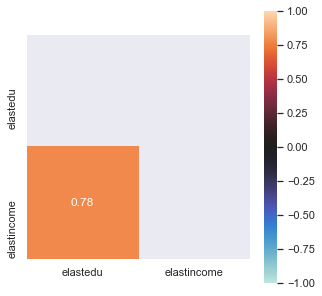

In [30]:
#Correlation
df = pd.DataFrame(elasticities,columns=['elastedu', 'elastincome'])
corrMatrix = df.corr()

mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
fig_heatmap, axs = plt.subplots(figsize=(5, 5))
axs = sns.heatmap(corrMatrix, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask, square=True, center=0)
plt.show()

In [31]:
## FIGURE 1 PLOT

In [32]:
shares_joint_ratio['ratio802'] = shares_joint_ratio['ratio80'] **2

In [33]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [34]:
#Defining the 1st regression function and results (WLS)
Y = shares_joint_ratio["elastedu"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results1 = model.fit()
#print(results1.summary())

In [35]:
#YHAT
shares_joint_ratio['hat'] = results1.predict()

In [36]:
#Defining 2nd regression function and results (WLS)
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastedu"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
#print(est.summary())

In [37]:
#YHAT
shares_joint_ratio['hat1'] = est.predict()

Text(0, 0.5, 'Education elasticity United States')

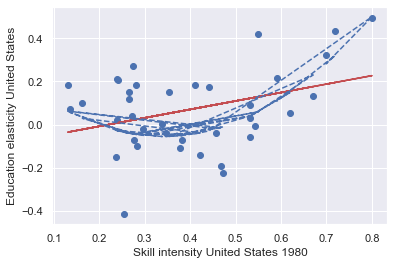

In [38]:
### FIGURE 1
x = shares_joint_ratio['ratio80']
y = shares_joint_ratio['elastedu']
hat1 = shares_joint_ratio['hat1']

from scipy.interpolate import *
p1 = np.poly1d(np.polyfit(x,y,1))
p2 = np.poly1d(np.polyfit(x,hat1,2))


from matplotlib.pyplot import *
%matplotlib inline 

plot(x,y,'o')
plot(x,np.polyval(p1,x),'r-')
plot(x,np.polyval(p2,x),'b--')
plt.xlabel('Skill intensity United States 1980')
plt.ylabel('Education elasticity United States')

In [39]:
shares_joint_ratio['sic'] = np.nan

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 1, 'sic'] = 17 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 2, 'sic'] = 121 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 3, 'sic'] = 19
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 4, 'sic'] = 18 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 5, 'sic'] = 121 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 6, 'sic'] = 22
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 7, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 8, 'sic'] = 45
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 9, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 10, 'sic'] = 14 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 11, 'sic'] = 67 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 12, 'sic'] = 11 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 13, 'sic'] = 12
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 14, 'sic'] = 13 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 15, 'sic'] = 6 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 16, 'sic'] = 86
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 17, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 18, 'sic'] = 32
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 19, 'sic'] = 68 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 20, 'sic'] = 116 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 21, 'sic'] = 115 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 22, 'sic'] = 91 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 23, 'sic'] = 104
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 24, 'sic'] = 92
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 25, 'sic'] = 64
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 26, 'sic'] = 122
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 27, 'sic'] = 6 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 28, 'sic'] = 95
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 29, 'sic'] = 76 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 30, 'sic'] = 73 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 31, 'sic'] = 72
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 32, 'sic'] = 81 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 33, 'sic'] = 118
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 34, 'sic'] = 119
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 35, 'sic'] = 113 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 36, 'sic'] = 113
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 37, 'sic'] = 113 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 38, 'sic'] = 126


In [40]:
skilloecdUS = pd.read_stata('skilloecdUS')
shares_joint_ratio_new = pd.merge(shares_joint_ratio, skilloecdUS, on='sic')

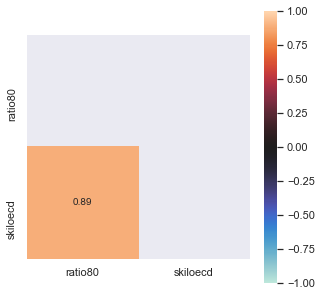

In [41]:
#correlation between skill intensity and skill adjusted
df2 = pd.DataFrame(shares_joint_ratio_new,columns=['ratio80', 'skiloecd'])
corrMatrix2 = df2.corr()
corrMatrix2

mask = np.zeros_like(corrMatrix2)
mask[np.triu_indices_from(mask)] = True
fig_heatmap, axs = plt.subplots(figsize=(5, 5))
axs = sns.heatmap(corrMatrix2, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask, square=True, center=0)
plt.show()

In [50]:
### INFO FOR THE TABLE 2 (PANEL A)
#1st regression function and results
Y = shares_joint_ratio["elastedu"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#2nd regression function and results
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastedu"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

#3rd regression function and results
Y = shares_joint_ratio["elastincome"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#4th regression function and results
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastincome"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.587
Date:                Tue, 23 Mar 2021   Prob (F-statistic):             0.0663
Time:                        12:45:36   Log-Likelihood:                 8.1695
No. Observations:                  38   AIC:                            -12.34
Df Residuals:                      36   BIC:                            -9.064
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1099      0.063     -1.745      0.0

In [49]:
### INFO FOR THE TABLE 2 (PANEL B)
shares_joint_ratio_new['skiloecd2'] = shares_joint_ratio_new['skiloecd'] **2

#1st regression function and results
Y = shares_joint_ratio_new["elastedu"]
X = shares_joint_ratio_new["skiloecd"]
w = shares_joint_ratio_new["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#2nd regression function and results
X = shares_joint_ratio_new[["skiloecd","skiloecd2"]] 
y = shares_joint_ratio_new["elastedu"]
w = shares_joint_ratio_new["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

#3rd regression function and results
Y = shares_joint_ratio_new["elastincome"]
X = shares_joint_ratio_new["skiloecd"]
w = shares_joint_ratio_new["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#4th regression function and results
X = shares_joint_ratio_new[["skiloecd","skiloecd2"]] 
y = shares_joint_ratio_new["elastincome"]
w = shares_joint_ratio_new["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.039
Date:                Tue, 23 Mar 2021   Prob (F-statistic):             0.0898
Time:                        12:45:30   Log-Likelihood:                 7.9048
No. Observations:                  38   AIC:                            -11.81
Df Residuals:                      36   BIC:                            -8.534
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1776      0.105     -1.694      0.0

In [44]:
#TABLE2

In [45]:
PanelA = ['','','','']
PanelB = ['','','','']
ratio80 = [0.322,-1.806,0.581,-2.325]
se1 = ['(0.170)','(0.707)','(0.264)','(1.129)']
ratio802 = ['',2.641,'',3.607,]
se2 = ['','(0.856)','', '(1.368)']
Constant1 = [-0.110,0.254,0.802,1.299,]
se3 = ['(0.0630)','(0.131)','(0.0977)','(0.209)']
R_squared1 = [0.091,0.285,0.119,0.265,]

skiloecd = [0.468,-4.532,0.824,-5.900]
se4 = ['(0.269)','(1.575)','(0.419)','(2.547)']
skiloecd2 = ['',5.865,'',7.887]
se5 = ['','(1.825)','', '(2.953)']
Constant2 = [-0.178, 0.826, 0.688, 2.037]
se6 = ['(0.105)','(0.326)','(0.163)','(0.527)']
R_squared2 = [0.078, 0.288, 0.097, 0.250]

rows = [PanelA, ratio80,se1,ratio802,se2,Constant1,se3,R_squared1,PanelB,skiloecd,se4,skiloecd2,se5,Constant2,se6,R_squared2]
index = ["Panel A","Skill intensity 1980",'',"Skill intensity 1980 squared",'',"Constant",'', "R^2","Panel B",
         "AD Skill intensity 1980",'',"AD Skill intensity 1980 squared",'',"Constant",'', "R^2"]
df1 = pd.DataFrame(data = rows, index=index, columns=['Education elasticity','Education elasticity','Income elasticity','Income elasticity'])
df1

,Education elasticity,Education elasticity,Income elasticity,Income elasticity
Panel A,,,,
Skill intensity 1980,0.322,-1.806,0.581,-2.325
,(0.170),(0.707),(0.264),(1.129)
Skill intensity 1980 squared,,2.641,,3.607
,,(0.856),,(1.368)
Constant,-0.11,0.254,0.802,1.299
,(0.0630),(0.131),(0.0977),(0.209)
R^2,0.091,0.285,0.119,0.265
Panel B,,,,
AD Skill intensity 1980,0.468,-4.532,0.824,-5.9
